# Simulation experiments (Simulations)

Plot results for simulation experiments (see ../scripts/simulations).

## Imports

In [1]:
# general
import sys
import os

In [2]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from scipy.stats import probplot

sc.settings.verbosity = 3

In [3]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from snakemake.utils import Paramspace

In [5]:
# local
sys.path.append('..')
sys.path.append('../scripts/simulations')
from sim_defaults import DEFAULT_PARAMS, ADATA_PATH

## Plot settings

In [6]:
SAVE_PLOTS = True

In [7]:
%config InlineBackend.figure_format = 'retina'

if SAVE_PLOTS:
    plt.rcParams['font.sans-serif'] = "Arial"
    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['font.size'] = 7
    sns.set_style("ticks")

In [8]:
PLOT_DIRECTORY = 'figures/simulations'
if not os.path.exists(PLOT_DIRECTORY):
    os.makedirs(PLOT_DIRECTORY)

In [9]:
TEST_COLORS = {
    'scDALI-Het': '#1f77b4',
    'scDALI-Het (Binomial)': '#0F3B5A',
    'scDALI-Hom': '#ff7f0e',
    'scDALI-Joint': '#2ca02c',
    'ANOVA': '#d62728',
    'OLS-LRT': '#808080'
}

In [10]:
TEST_NAME_DICT = {
    'DaliHet': 'scDALI-Het',
    'DaliHetBinomial': 'scDALI-Het (Binomial)',
    'DaliHom': 'scDALI-Hom',
    'DaliJoint': 'scDALI-Joint',
    'ANOVA': 'ANOVA',
    'OLS': 'OLS-LRT'
}

In [11]:
def save_plot(fig, name):    
    fig.savefig(PLOT_DIRECTORY + '/' + name + '.svg', dpi=350)

## Constants & function definitions

In [12]:
COLUMNS = DEFAULT_PARAMS.keys()

def add_default_params(df):
    for c in COLUMNS:
        if c not in df.columns:
            df[c] = DEFAULT_PARAMS[c]
    return df

In [13]:
COL_ORDER = pd.read_csv('../scripts/simulations/params/params_all.csv').columns
COL_ORDER

Index(['test', 'sim_overdisp', 'sim_kern_var', 'sim_kern_mix', 'seed',
       'sim_kern_disc', 'test_cellstate', 'test_cellstate_d', 'ncells',
       'npeaks', 'tcounts', 'tcounts_mean', 'sim_kern_cont'],
      dtype='object')

In [14]:
SIM_RESULTS_DIR = '../scripts/simulations/results'

# Significance threshold for determining discoveries
ALPHA_CUTOFF = .05

def compute_discoveries(fname):
    return (pd.read_csv(os.path.join(SIM_RESULTS_DIR, fname), header=None) < ALPHA_CUTOFF).mean()

def compute_median_p(fname):
    return pd.read_csv(os.path.join(SIM_RESULTS_DIR, fname), header=None).median()

def compute_quantiles(fname):
    x = pd.read_csv(os.path.join(SIM_RESULTS_DIR, fname), header=None).to_numpy().flatten()
    x = x[~np.isnan(x)]
    (osm, osr), _ = scipy.stats.probplot(x, dist='uniform')
    return pd.DataFrame({'osm': -np.log10(osm), 'osr': -np.log10(osr)})

## Calibration for varying numbers of cells & cell states

In [15]:
df = add_default_params(pd.read_csv('../scripts/simulations/params/params_null3.csv'))[COL_ORDER]
df['filename'] = list(Paramspace(df).instance_patterns) 
df['filename'] = df['filename'] + '.txt'

In [16]:
df['Test'] = df['test'].replace(TEST_NAME_DICT)

In [17]:
df['median_p'] = df['filename'].apply(compute_median_p)
df['inflation_factor'] = np.log10(df['median_p'])/np.log10(0.5)

In [18]:
d = df.query('inflation_factor < 0.5')['test_cellstate_d'].max()
df = df.query('test_cellstate_d > @d')

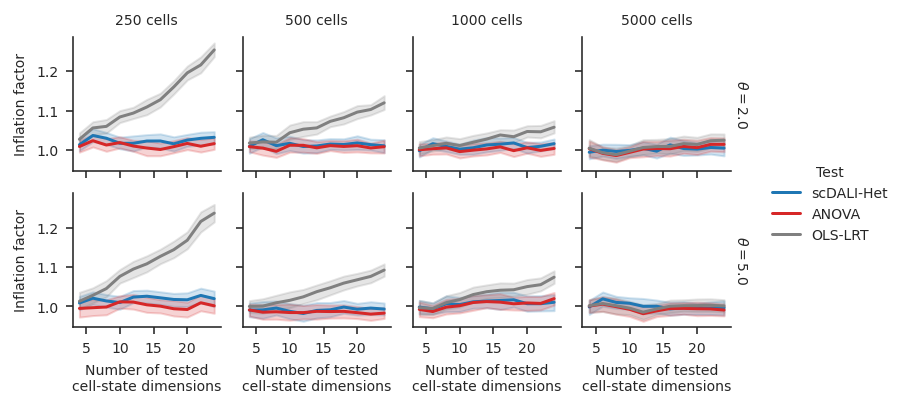

In [19]:
g = sns.relplot(
    x='test_cellstate_d', 
    y='inflation_factor', 
    hue='Test', 
    col='ncells', 
    row='sim_overdisp', 
    data=df,
    kind='line', 
    markers=True,
    palette=TEST_COLORS,
    height=1.35,
    facet_kws={'margin_titles': True})
g.set_titles(col_template=r"{col_name} cells", row_template=r"$\theta=${row_name}")
plt.xticks([5, 10, 15, 20])
g.set_xlabels('Number of tested\ncell-state dimensions')
g.set_ylabels('Inflation factor');

In [20]:
if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/calibration_by_tested_dims.svg', dpi=350)

## Power for detecting discrete vs. continuous effects

In [21]:
df = add_default_params(pd.read_csv('../scripts/simulations/params/params_contdisc.csv'))[COL_ORDER]
df['filename'] = list(Paramspace(df).instance_patterns) 
df['filename'] = df['filename'] + '.txt'

In [22]:
df['Test'] = df['test'].replace(TEST_NAME_DICT)

In [23]:
df['power'] = df['filename'].apply(compute_discoveries)

In [24]:
df['sim_kern_mix'] = (100 * df['sim_kern_mix']).astype(int)

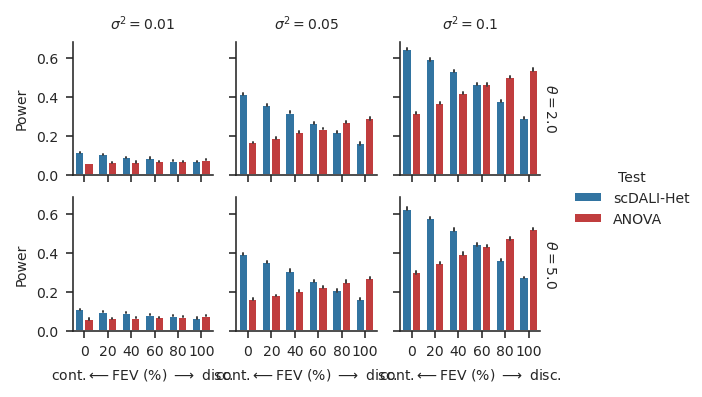

In [25]:
g = sns.catplot(
    x='sim_kern_mix', 
    y='power', 
    hue='Test', 
    col='sim_kern_var', 
    row='sim_overdisp', 
    data=df,
    kind='bar',
    linewidth=1,
    errwidth=1,
    edgecolor='White',
    palette=TEST_COLORS,
    height=1.35,
    margin_titles=True)
g.set_titles(col_template=r"$\sigma^2=${col_name}", row_template=r"$\theta=${row_name}")
g.set_xlabels(r'cont.$\longleftarrow$FEV (%) $\longrightarrow$ disc.')
g.set_ylabels('Power');

In [26]:
if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/power_by_contdisc.svg', dpi=350)

Main figure plot

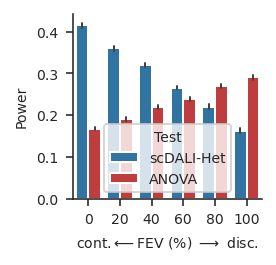

In [27]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
sns.barplot(
    x='sim_kern_mix', 
    y='power', 
    hue='Test', 
    data=df.query('sim_kern_var == 0.05 and sim_overdisp == 2'),
    linewidth=1,
    errwidth=1,
    edgecolor='White',
    palette=TEST_COLORS,
    ax=ax)
ax.set(
    xlabel=r'cont.$\longleftarrow$FEV (%) $\longrightarrow$ disc.',
    ylabel='Power')
sns.despine()

In [28]:
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/power_by_contdisc_main.svg', dpi=350)

## Power for detecting homogeneous vs. heterogeneous effects

In [29]:
df = add_default_params(pd.read_csv('../scripts/simulations/params/params_hethom.csv'))[COL_ORDER]
df['filename'] = list(Paramspace(df).instance_patterns) 
df['filename'] = df['filename'] + '.txt'

In [30]:
df['Test'] = df['test'].replace(TEST_NAME_DICT)

In [31]:
df['power'] = df['filename'].apply(compute_discoveries)

In [32]:
df['sim_kern_mix'] = (100 * df['sim_kern_mix']).astype(int)

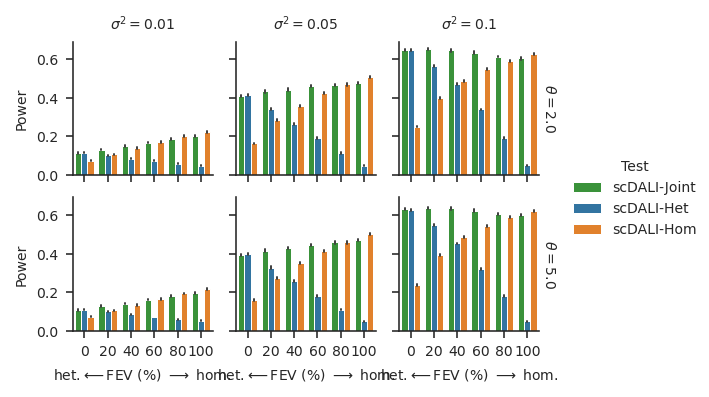

In [33]:
g = sns.catplot(
    x='sim_kern_mix', 
    y='power', 
    hue='Test', 
    col='sim_kern_var', 
    row='sim_overdisp', 
    data=df,
    kind='bar',
    linewidth=0.5,
    errwidth=1,
    edgecolor='White',
    palette=TEST_COLORS,
    height=1.35,
    margin_titles=True)
g.set_titles(col_template=r"$\sigma^2=${col_name}", row_template=r"$\theta=${row_name}")
g.set_xlabels(r'het.$\longleftarrow$FEV (%) $\longrightarrow$ hom.')
g.set_ylabels('Power');

In [34]:
if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/power_by_hethom.svg', dpi=350)

Main figure plot

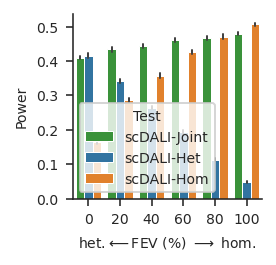

In [35]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
sns.barplot(
    x='sim_kern_mix', 
    y='power', 
    hue='Test', 
    data=df.query('sim_kern_var == 0.05 and sim_overdisp == 2'),
    linewidth=0.5,
    errwidth=1,
    edgecolor='White',
    palette=TEST_COLORS, 
    ax=ax)
ax.set(
    xlabel=r'het.$\longleftarrow$FEV (%) $\longrightarrow$ hom.',
    ylabel='Power')
sns.despine()

In [36]:
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/power_by_hethom_main.svg', dpi=350)

## Visualize distribution of dispersion parameters estimated from real data

In [37]:
adata = sc.read(ADATA_PATH)

# subsample to 1000 peaks
# N = 1000
# np.random.seed(123)
# adata = adata[:, np.random.choice(adata.shape[1], N, replace=False)]

In [38]:
A = adata.X.A
D = adata.layers['allelic_total'].A

In [39]:
from scdali.utils.stats import fit_polya, reparameterize_polya_alpha

In [40]:
alphas = list()
for i in range(adata.shape[1]):
    print(i, end='\r')
    a = A[:, i]
    d = D[:, i]
    a = a[d > 0]
    d = d[d > 0]
    alpha, _ = fit_polya(data = np.vstack([a, d-a]).T)
    alphas.append(alpha)

params = [reparameterize_polya_alpha(a) for a in alphas]
mus = [p[0][0] for p in params]
thetas = [1/p[1] for p in params]

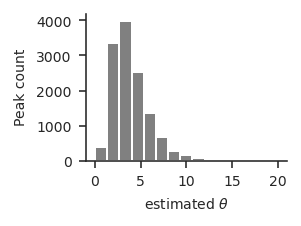

In [41]:
fig, ax = plt.subplots(figsize=(1.8, 1.35))
ax.hist(thetas, bins=15, range=(0, 20), color='grey')
ax.set(xlabel=r'estimated $\theta$', ylabel='Peak count')
ax.set(xticks=[0, 5, 10, 15, 20])
sns.despine()

In [42]:
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/theta_distribution.svg', dpi=350)

## Null distribution

Homogeneous but no heterogeneous effects

In [59]:
df = add_default_params(pd.read_csv('../scripts/simulations/params/params_null1.csv'))[COL_ORDER]
df['filename'] = list(Paramspace(df).instance_patterns) 
df['filename'] = df['filename'] + '.txt'

In [60]:
df['Test'] = df['test'].replace(TEST_NAME_DICT)

In [61]:
X = df['filename'].apply(compute_quantiles).tolist()

cols = ['Test', 'sim_kern_var', 'sim_overdisp']

for i, idx in enumerate(df.index): 
    for col in [cols]:
        X[i][col] = df.loc[idx, col]

df = pd.concat(X)

In [62]:
df = df.query('Test != "OLS-LRT"')

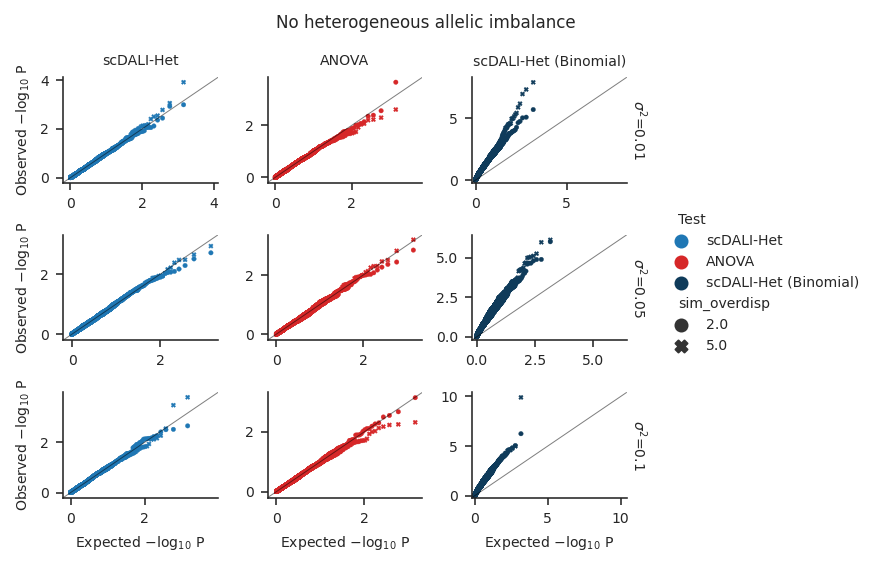

In [65]:
g = sns.relplot(
    x='osm', y='osr', 
    row='sim_kern_var', 
    col='Test',
    style='sim_overdisp', 
    data=df,
    s=5,
    hue='Test',
    palette=TEST_COLORS,
    height=1.2,
    edgecolor=None,
    rasterized=True,
    aspect=1.3,
    facet_kws={'margin_titles': True, 'sharey': False, 'sharex': False})
for ax in g.fig.axes:
    plot_range = [-0.2, max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.set_xlim(plot_range)
    ax.set_ylim(plot_range)
    diag_range = plot_range
    ax.plot(plot_range, diag_range, alpha=0.5, linewidth=0.5, c='black')

g.fig.suptitle('No heterogeneous allelic imbalance', y=1.05)
g.set_axis_labels(r'Expected $-\log_{10}$ P', r'Observed $-\log_{10}$ P')
g.set_titles(col_template='{col_name}', row_template=r'$\sigma^2$={row_name}')
plt.show()

if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/calibration_no_hetai.svg', dpi=350)

Neither homogeneous nor heterogeneous effects

In [48]:
df = add_default_params(pd.read_csv('../scripts/simulations/params/params_null2.csv'))[COL_ORDER]
df['filename'] = list(Paramspace(df).instance_patterns) 
df['filename'] = df['filename'] + '.txt'

In [49]:
df['Test'] = df['test'].replace(TEST_NAME_DICT)

In [50]:
X = df['filename'].apply(compute_quantiles).tolist()

cols = ['Test', 'sim_kern_var', 'sim_overdisp']

for i, idx in enumerate(df.index): 
    for col in [cols]:
        X[i][col] = df.loc[idx, col]

df = pd.concat(X)

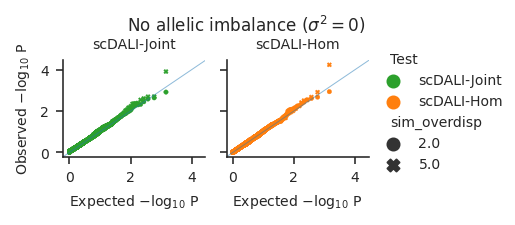

In [51]:
g = sns.relplot(
    x='osm', y='osr', 
    col='Test', 
    style='sim_overdisp', 
    data=df,
    s=5,
    hue='Test',
    palette=TEST_COLORS,
    height=1.35,
    edgecolor=None,
    aspect=1,
    rasterized=True)
for ax in g.fig.axes:
    plot_range = [-0.2, max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.set_xlim(plot_range)
    ax.set_ylim(plot_range)
    diag_range = plot_range
    ax.plot(plot_range, diag_range, alpha=0.5, linewidth=0.5)
    
g.fig.suptitle(r'No allelic imbalance ($\sigma^2=0$)', y=1.05)
g.set_axis_labels(r'Expected $-\log_{10}$ P', r'Observed $-\log_{10}$ P')
g.set_titles(col_template='{col_name}', row_template=r'$\theta$={row_name}')


plt.show()

if SAVE_PLOTS:
    g.fig.savefig(PLOT_DIRECTORY + '/calibration_no_ai.svg', dpi=350)

## Kernel matrices

In [52]:
from scdali.utils.simulate import create_linear_kernel, create_cluster_kernel

In [53]:
np.random.seed(123)

In [54]:
N = 1000

In [55]:
adata = sc.read(ADATA_PATH)
adata = adata[np.random.choice(adata.shape[0], 1000, replace=False), :]
adata = adata[adata.obs['leiden_vae'].sort_values().index, :]

In [56]:
K_hom = np.ones((N, N))
K_vae = create_linear_kernel(adata.obsm['X_vae'])
K_leiden = create_cluster_kernel(adata.obs['leiden_vae'])

K_vae = (K_vae - K_vae.min()) / (K_vae.max() - K_vae.min())

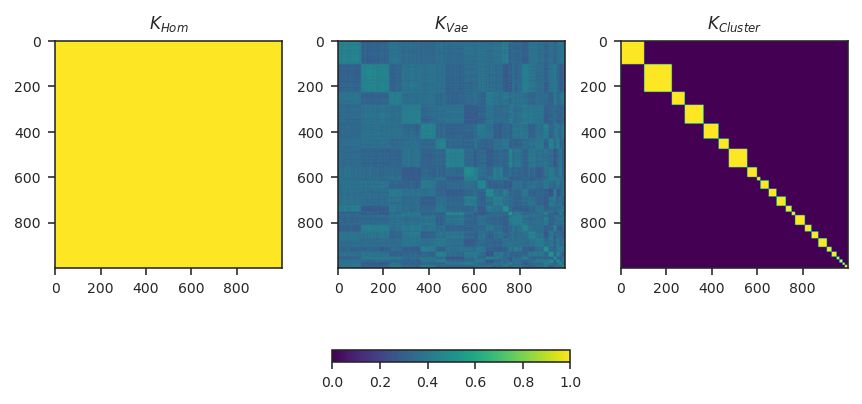

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(6, 4))
ax = axes[0]
p = ax.imshow(K_hom, cmap=plt.cm.viridis, vmin=0, vmax=1)
ax.set(title='$K_{Hom}$')
ax = axes[1]
p = ax.imshow(K_vae, cmap=plt.cm.viridis, vmin=0, vmax=1)
ax.set(title='$K_{Vae}$')
ax = axes[2]
p = ax.imshow(K_leiden, cmap=plt.cm.viridis, vmin=0, vmax=1)
ax.set(title='$K_{Cluster}$')
plt.tight_layout()
plt.colorbar(p, ax=axes, orientation='horizontal', shrink=0.3)

In [58]:
if SAVE_PLOTS:
    fig.savefig(PLOT_DIRECTORY + '/sim_kernels.svg', dpi=350)